In [32]:
%cd "/home/y0065120/Dokumente/Leichtwerk/Projects/helics-opt/"

# Third-party imports
import pyansys
import pandas as pd
import numpy as np
from pyOpt import Optimization
from pyOpt import ALPSO
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
#%matplotlib widget
import itkwidgets
from ipywidgets import interactive, interact_manual, interact
import ipywidgets as widgets
import pyvista as pv
import locale
import tikzplotlib

# Local imports
# from femodel import Femodel
from util_mapdl import Material
from util_mapdl.post_functions import fc_puck


locale.setlocale(locale.LC_ALL, 'de_DE')
plt.rcParams['axes.formatter.use_locale'] = True

/home/y0065120/Dokumente/Leichtwerk/Projects/helics-opt


In [2]:
class Femodel:
    
    def __init__(self, mapdl, mesh_factor=0.2):
        self.mapdl = mapdl
        self.__ansys_input_filename = '_ansys_input_file'
        self.mesh_density_factor = mesh_factor

    def cdread(self):
        """
        Read in the .cdb database file generated by the pre-processing 
        method.

        """
        
        self.mapdl.prep7()
        self.mapdl.cdread('all', self.__ansys_input_filename, 'cdb')        
        
    def clear(self):
        """Resets the MAPDL Session. """
        
        self.mapdl.finish()
        self.mapdl.clear('NOSTART')
        
    def pre_processing(self):

        self.mapdl.prep7() # Enter Preprocessing Routine
        
        # Space for basic parameters and settings
        self.mapdl.seltol(1e-4)
        self.mapdl.et('1','SHELL281')    
        self.mapdl.keyopt(1,8,1)

        # Material Parameters
        for key in self.materials:
            self.materials[key].assign_mp()

        # Abmaße des Balkens
        l = 1000 
        b = 10
        h = 30
    
        with self.mapdl.chain_commands:
            self.mapdl.et('1','SHELL281')
            self.mapdl.keyopt(1,8,1)
            
            # Modellgeometrie-Erstellung
            self.mapdl.k(1,0,0,h/2)
            self.mapdl.k(2,b,0,h/2)
            self.mapdl.k(3,b,l,h/2)
            self.mapdl.k(4,0,l,h/2)
            
            self.mapdl.k(5,0,0,-h/2)
            self.mapdl.k(6,b,0,-h/2)
            self.mapdl.k(7,b,l,-h/2)
            self.mapdl.k(8,0,l,-h/2)    
            
            self.mapdl.a(1,2,3,4)
            self.mapdl.a(5,6,7,8)    
            self.mapdl.a(6,7,3,2)
            
            # Mesh-Seeds
            self.mapdl.lsel('s','loc','x',b/2)
            self.mapdl.lesize('all','','',self.mesh_density_factor*b)
            
            self.mapdl.lsel('s','loc','y',l/2)
            self.mapdl.lesize('all','','',self.mesh_density_factor*l)
            
            self.mapdl.lsel('s','loc','z',0)
            self.mapdl.lesize('all','','',self.mesh_density_factor*h)
            
            # Vernetzung und Zuweisung Sections
            self.mapdl.mshkey(1)
            self.mapdl.mshape(0,'2d')
            self.mapdl.allsel('all')
            
            self.mapdl.sectype(100,'shell','','Dummy')
            self.mapdl.secdata(0.1,1,90.,3)
            self.mapdl.allsel('all')
            self.mapdl.amesh('all')
            
        self.mapdl.allsel('all')
        self.mapdl.cdwrite('all', self.__ansys_input_filename, 'cdb')
        self.mapdl.finish()
        self.mapdl.clear('nostart')
        
    def change_design_variables(self, divisions, topspar, bottomspar, web):

        # Abmaße des Balkens
        l = 1000 
        b = 10
        h = 30        
        
        # Überprüfen und sortieren der Trennstellen
        divisions = set(divisions)
        divisions = list(np.sort(list(divisions)))
        divisions.insert(0, 0)
        divisions.append(l)
        intervals = []
        for x in range(len(divisions)-1):
            intervals.append([divisions[x], divisions[x+1]])
    
            
        with self.mapdl.chain_commands:
            def secnum():
                secnum.counter+=1
                return secnum.counter
            secnum.counter = 0
    
            for i in intervals:       
                index = intervals.index(i)
                
                self.mapdl.sectype(secnum(),'shell','','Top_spar')
                self.mapdl.secdata(topspar[index],1,90.,3)
                self.mapdl.esel('s','cent','z',h/2)
                self.mapdl.esel('r','cent','y',i[0],i[1])
                self.mapdl.emodif('all','secnum',secnum.counter)
                
                self.mapdl.sectype(secnum(),'shell','','Bottom_spar')
                self.mapdl.secdata(bottomspar[index],1,90.,3)
                self.mapdl.esel('s','cent','z',-h/2)
                self.mapdl.esel('r','cent','y',i[0],i[1])
                self.mapdl.emodif('all','secnum',secnum.counter)
                
                self.mapdl.sectype(secnum(),'shell','','Shearweb')
                self.mapdl.secdata(web[index]/2,1,45.,3)                     #### achtung /2
                self.mapdl.secdata(web[index]/2,1,-45.,3)
                self.mapdl.esel('s','cent','x',b)
                self.mapdl.esel('r','cent','y',i[0],i[1])
                self.mapdl.emodif('all','secnum',secnum.counter)
                
            # Lastdefinition und Lösung
            # RBD
            self.mapdl.nsel('s','loc','x',0)
            self.mapdl.d('all','ux',0)
            self.mapdl.nsel('s','loc','y',0)
            self.mapdl.d('all','all',0)
            # Last
            self.mapdl.esel('s','cent','z',h/2)
            self.mapdl.sfe('all','','pres','0',-0.05/20)
            self.mapdl.esel('s','cent','z',-h/2)
            self.mapdl.sfe('all','','pres','0',-0.05/20)
            self.mapdl.allsel('all')
        
    def solve(self):
        """Solve the FE-Model. """
        
        self.mapdl.run('/SOLU')
        self.mapdl.antype('static')
        self.mapdl.outres('all','all')
        self.mapdl.solve()
        self.mapdl.finish()
        
    def post_processing(self, divisions):
        
        self.mapdl.post1() # Enter Post-processing Routine
        
        # Assign Failure Criteria Values
        for key in self.materials:
            self.materials[key].assign_fc()
        
        self.mapdl.fctyp('dele','all')
        self.mapdl.fctyp('add','pfib')
        self.mapdl.fctyp('add','pmat')        
        
        self.mapdl.allsel('all')
        
        # Abmaße des Balkens
        l = 1000 
        b = 10
        h = 30          
        
        # Überprüfen und sortieren der Trennstellen
        divisions = set(divisions)
        divisions = list(np.sort(list(divisions)))
        divisions.insert(0, 0)
        divisions.append(l)
        intervals = []
        for x in range(len(divisions)-1):
            intervals.append([divisions[x], divisions[x+1]])
        
        I_f_t, I_m_t, I_f_b, I_m_b, I_f_w, I_m_w = ([] for i in range(6))
        for i in intervals:
            self.mapdl.esel('s','cent','y',i[0],i[1])
            self.mapdl.esel('r','cent','z',h/2)
            F, M = fc_puck(self.mapdl)
            I_f_t.append(F)
            I_m_t.append(M)
            
            self.mapdl.esel('s','cent','y',i[0],i[1])
            self.mapdl.esel('r','cent','z',-h/2)
            F, M = fc_puck(self.mapdl)
            I_f_b.append(F)
            I_m_b.append(M)
            
            self.mapdl.esel('s','cent','y',i[0],i[1])
            self.mapdl.esel('r','cent','x',b)
            F, M = fc_puck(self.mapdl)
            I_f_w.append(F)
            I_m_w.append(M)
        I = list(I_f_t + I_f_b + I_f_w + I_m_t + I_m_b + I_m_w)
        
        self.mapdl.allsel('all')
        self.mapdl.get('M','elem','0','mtot','z')
        mtot = self.mapdl.parameters['M']
        
        return mtot, I
    
    def evaluate(self, x):
    
        x = np.array(x)
        divisions = list(x[0:2]*5)
        if divisions[0] == divisions[1]:
            divisions[0] = divisions[0]-5
        topspar = list(x[2:5])
        bottomspar = list(x[5:8])
        web = list(x[8:11])
        
        self.cdread()
        self.change_design_variables(divisions, topspar, bottomspar, web)
        self.solve()
        mtot, I = self.post_processing(divisions)
        self.clear()
        
        return mtot, I
        
    @property
    def materials(self):
        """
        The Materials assigned to the Model.

        Returns
        -------
        materials : Dict

        """
        return self.__materials
    
    @materials.setter
    def materials(self, materials):
        self.__materials = materials
        
        for key in materials:
            self.__materials[key].load_from_db()
            
    @property
    def mesh_density_factor(self):
        """
        Integer factor to control the mesh density.

        Returns
        -------
        mesh_density_factor : int

        """
        return self.__mesh_density_factor
            
    @mesh_density_factor.setter
    def mesh_density_factor(self, mesh_density_factor):
        self.__mesh_density_factor = mesh_density_factor

In [3]:
ansys_path = '/home/y0065120/Dokumente/Leichtwerk/Projects/ansys-1/'
jobname ='job-0'

mapdl = pyansys.launch_mapdl(run_location=ansys_path,
                            nproc=1,
                            override=True,
                            loglevel='error',
                            additional_switches='-smp -d X11C',
                            jobname=jobname,
                            allow_ignore=True,
                            mode='console',
                            )

femodel = Femodel(mapdl)

femodel.materials = {'flaxpreg': Material(mapdl, 'FLAXPREG-T-UD', 1)}

femodel.pre_processing()

In [4]:
def objfunc(x):
    mtot, I = femodel.evaluate(x)
    
    # Get objective and constraint vector
    f = np.round(mtot*10**6,3)
    g = list(np.round(np.array(I)-1,3))
    
    # Print current Function Evaluation for monitoring purpuses
    objfunc.counter+= 1
    print(objfunc.counter,str(np.round(f,2)).zfill(5),str(int(x[0])).zfill(3),str(int(x[1])).zfill(3),list(np.round(x[2:],3)))
    
    time.sleep(0.01)
    fail = 0
    return f, g, fail
objfunc.counter = 0

In [5]:
opt_prob = Optimization('Faserverbundbalken',objfunc)

# Add variables
t_layer = 0.185
opt_prob.addVar('y1', 'i', lower=4, upper=100, value=30)
opt_prob.addVar('y2', 'i', lower=4, upper=150, value=90)
opt_prob.addVar('n_top1' ,'c', lower=1*0.1, upper=1.5, value=3*t_layer)
opt_prob.addVar('n_top2' ,'c', lower=1*0.1, upper=1.5, value=3*t_layer)
opt_prob.addVar('n_top3' ,'c', lower=1*t_layer, upper=0.75, value=2*t_layer)
opt_prob.addVar('n_bot1' ,'c', lower=1*0.1, upper=1.5, value=5*t_layer)
opt_prob.addVar('n_bot2' ,'c', lower=1*0.1, upper=1.5, value=4*t_layer)
opt_prob.addVar('n_bot3' ,'c', lower=1*t_layer, upper=0.75, value=2*t_layer)
opt_prob.addVar('n_web1' ,'c', lower=1*t_layer, upper=1.5, value=2*t_layer)
opt_prob.addVar('n_web2' ,'c', lower=1*t_layer, upper=1.5, value=1*t_layer)
opt_prob.addVar('n_web3' ,'c', lower=1*t_layer, upper=0.75, value=1*t_layer)

# Add objective
opt_prob.addObj('f')

# Add constraints
opt_prob.addConGroup('g_fib_top', 3, 'i')
opt_prob.addConGroup('g_fib_bot', 3, 'i')
opt_prob.addConGroup('g_fib_web', 3, 'i')
opt_prob.addConGroup('g_mat_top', 3, 'i')
opt_prob.addConGroup('g_mat_bot', 3, 'i')
opt_prob.addConGroup('g_mat_web', 3, 'i')

In [6]:
# Instantiate Optimizer
alpso = ALPSO()
alpso.setOption('fileout',1)

alpso_path = "/home/y0065120/Dokumente/Leichtwerk/Projects/ALPSO/"
filename = 'Balken_Output_ALPSO'

alpso.setOption('filename', alpso_path+filename)
alpso.setOption('SwarmSize', 40)
alpso.setOption('stopIters', 2)      
alpso.setOption('rinit', 1.)
alpso.setOption('itol', 0.01)

def coldstart():    
    alpso(opt_prob, store_hst=True)
    print(opt_prob.solution(0))

In [7]:
divisions=[465, 215]
top=[0.723540, 0.389293, 0.191526]
bot=[0.769614, 0.502903, 0.215506]
web=[0.185183, 0.185000, 0.185239]

In [8]:
femodel.clear()
femodel.cdread()
femodel.change_design_variables(divisions, top, bot, web)
femodel.solve()
mtot, I = femodel.post_processing(divisions)

In [9]:
@interact_manual(switch=widgets.Checkbox(value=True, description='True = Fib', disabled=False),
                 layer=widgets.IntSlider(min=1, max=5, value=1, description='Layer:'))
def plot_puck(layer, switch):
    mapdl.post1()
    mapdl.layer(layer)
    
    if switch:
        mapdl.etable('fib','fail','pfib')
    else:
        mapdl.etable('fib','fail','pmat')

    with open('pretab.txt', 'w') as f:
        f.write(mapdl.pretab('fib'))

    etable = []
    with open('pretab.txt', 'r') as f:
        for line_number, line in enumerate(f):
            split_line = line.split()
            try:
                etable.append([int(split_line[0]), float(split_line[1])])
            except:
                pass
    etable=np.array(etable)          

    etb_scalar = []
    for elem in mapdl.result.grid['ansys_elem_num']:
        etb_scalar.append(etable[elem-1,1])
    etb_scalar = np.array(etb_scalar)

    #plotter = pv.Plotter(notebook=True)
    #plotter = pv.Plotter()
    plotter = pv.PlotterITK()
    plotter.add_mesh(mapdl.result.grid,
                     scalars=etb_scalar, #etable[:,1],
                     #cmap='plasma',
                     #clim=[0,1],
                     )
    #plotter.show_axes()
    #plotter.set_background(color='w')
    #plotter.add_scalar_bar(position_x=0.2)
    cpos = plotter.show(cpos=[0, 0, 1],
                        cmap='coolwarm'
                       # use_ipyvtk=True,
                       ) 

interactive(children=(IntSlider(value=1, description='Layer:', max=5, min=1), Checkbox(value=True, description…

In [22]:
mapdl.post1()
mapdl.layer(1)
mapdl.etable('fib','fail','pfib')

with open('pretab.txt', 'w') as f:
    f.write(mapdl.pretab('fib'))
    
etable = []
with open('pretab.txt', 'r') as f:
    for line_number, line in enumerate(f):
        split_line = line.split()
        try:
            etable.append([int(split_line[0]), float(split_line[1])])
        except:
            pass
etable=np.array(etable)          

etb_scalar = []
for elem in mapdl.result.grid['ansys_elem_num']:
    etb_scalar.append(etable[elem-1,1])
etb_scalar = np.array(etb_scalar)

rst = mapdl.result.grid
rst['etable'] = etb_scalar

p_start = (5, 0, -15)
p_end = (5, 1000,-15)
line = pv.Line(p_start, p_end, resolution=200)
out = line.sample(rst)

p_pull = (5, 0, 15)
p_end_pull = (5, 1000, 15)
line2 = pv.Line(p_pull, p_end_pull, resolution=200)
out_pull = line2.sample(rst)

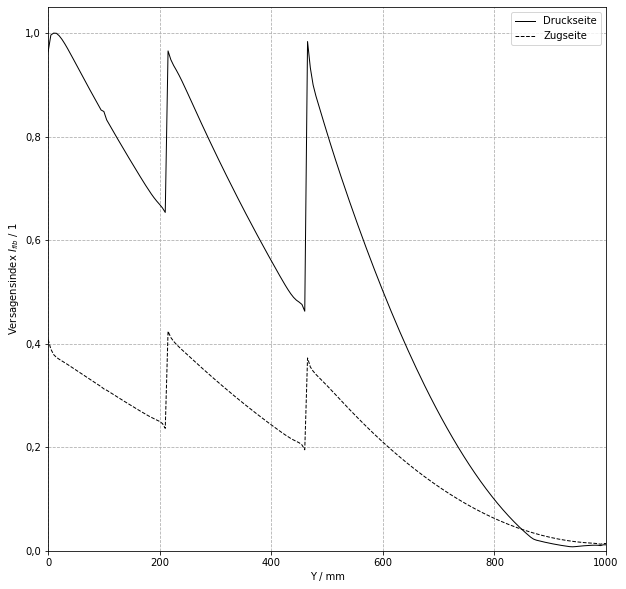

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

plt.subplot(1,1,1)
plt.plot(list(out.points[:, 1]),
         list(out['etable']),
         color='black',
         linewidth='1',
         label='Druckseite')

plt.plot(list(out_pull.points[:, 1]),
         list(out_pull['etable']),
         color='black',
         linewidth='1',
         linestyle='dashed',
         label='Zugseite')

ax.set_box_aspect(1)
plt.grid(True, which='major', linestyle='--')
plt.xlim(0,1000)
plt.ylim(0,1.05)
plt.legend()
plt.xlabel('Y / mm')
plt.ylabel('Versagensindex $I_{fib}$ / 1')

tikzplotlib.save("balken_path.tex")

In [ ]:
max_fib = []

for i in range(200):
    mapdl.esel('s','cent','y',i*5, (i+1)*5)
    
    mapdl.post1()
    mapdl.layer(1)
    mapdl.etable('fib','fail','pfib')

    with open('pretab.txt', 'w') as f:
        f.write(mapdl.pretab('fib'))

    etable = []
    with open('pretab.txt', 'r') as f:
        for line_number, line in enumerate(f):
            split_line = line.split()
            try:
                etable.append([int(split_line[0]), float(split_line[1])])
            except:
                pass
    etable=np.array(etable)   
    
    max_fib.append(max(etable[:,1]))
    

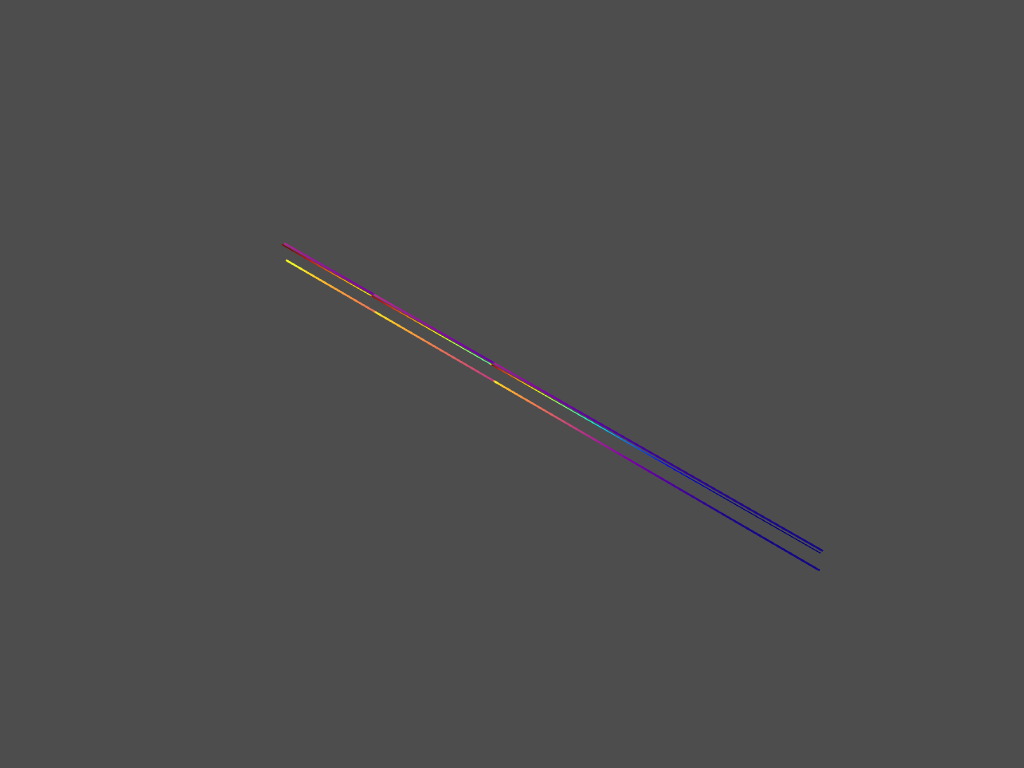

[(1123.3708041354787, 1615.8708041354787, 1115.8708041354787),
 (7.5, 500.0, 0.0),
 (0.0, 0.0, 1.0)]

In [62]:
top_slice = rst.slice('z',(5, 0, 15))

pl = pv.Plotter()
#pl = pv.PlotterITK()
pl.add_mesh(out_pull,
            scalars=out_pull['etable'],
            cmap='plasma',
            line_width=2,
            clim=[0,1])
pl.add_mesh(out,
            scalars=out['etable'],
            cmap='plasma',
            line_width=2,
            clim=[0,1])
pl.add_mesh(top_slice, scalars=out['etable'])

#pl.add_mesh(rst, color='w', style='wireframe')

pl.show()

In [57]:
top_slice

PolyData (0x7fc9341942e0)
  N Cells:	200
  N Points:	201
  X Bounds:	1.000e+01, 1.000e+01
  Y Bounds:	0.000e+00, 1.000e+03
  Z Bounds:	1.500e+01, 1.500e+01
  N Arrays:	11

In [63]:
I

[0.408380841,
 0.425919175,
 0.395245896,
 1.00570401,
 0.965544326,
 0.983700261,
 0.609994291,
 0.586716813,
 0.59250347,
 0.327246964,
 0.499458926,
 0.99144291,
 0.35551855,
 0.28544393,
 0.800303632,
 1.00349356,
 0.963433412,
 0.792395827]